In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
source_dir = '../../data_directory/metadata/'
save_dir = '../../data_directory/mean_sections/'

In [3]:
# Read in ice class data and station metadata
ice_class = pd.read_csv(source_dir + 'observed_ice_edge_bridgecam_updated072425.csv')

## Read in Station Data
all_stations = pd.read_csv(source_dir + 'station_metadata_laps.csv')

all_stations = pd.merge(all_stations, ice_class)

In [4]:
stations = all_stations[all_stations['section'] != 'TRAPR']

In [5]:
## Split into individual repeat transits to ensure only one ice edge detected per transit
section_dfs = {section: df for section, df in stations.groupby('section')}
# section_dfs.keys()

In [6]:
for section in section_dfs.keys():
    df = section_dfs[section]

    # Detect which stations border change in sea ice
    df['ice_edge'] = df['ice_obs'] != df['ice_obs'].shift(-1)
    # Where ice edge is false, check to be sure there isnt an ice edge in the other direction
    df.loc[~df['ice_edge'], 'ice_edge'] = df['ice_obs'] != df['ice_obs'].shift(1)

    # Ends NAN
    df.loc[df.index[-1], 'ice_edge'] = np.nan   # last row has no next
    df.loc[df.index[0], 'ice_edge'] = np.nan   # first row has no previous

    df['southern_ice'] = np.min(df[df['ice_obs']=='ice']['dist_km'])
    df['northern_miz'] = np.max(df[df['ice_obs']=='miz']['dist_km'])
    df['southern_miz'] = np.min(df[df['ice_obs']=='miz']['dist_km'])
    df['northern_ow'] = np.max(df[df['ice_obs']=='ow']['dist_km'])

In [7]:
transects = pd.concat(section_dfs)
# transects

In [8]:
ice_demarcations = transects[['section', 'southern_ice','northern_miz', 'southern_miz', 'northern_ow']].drop_duplicates()
# ice_demarcations

In [9]:
## Group by transect for correct north to south distance
hre = transects[transects['section'].fillna('').str.match(r'^HRE')].copy()
hre['dist_n2s'] = hre['dist_km'].transform(lambda x: x.max() - x)

hr = transects[transects['section'].fillna('').str.match(r'^HR\d')].copy()
hr['dist_n2s'] = hr['dist_km'].transform(lambda x: x.max() - x)

hr_hre = pd.concat([hr, hre])
# hr_hre

In [10]:
hr_hre_sections = {hr_hre: df for hr_hre, df in hr_hre.groupby('section')}

In [11]:
for section in hr_hre_sections.keys():
    df = hr_hre_sections[section]

    df['northern_end_of_transect'] = np.min(df[df['ice_obs']=='ice']['dist_n2s'])
    df['southern_ice'] = np.max(df[df['ice_obs']=='ice']['dist_n2s'])
    df['northern_miz'] = np.min(df[df['ice_obs']=='miz']['dist_n2s'])
    df['southern_miz'] = np.max(df[df['ice_obs']=='miz']['dist_n2s'])
    df['northern_ow'] = np.min(df[df['ice_obs']=='ow']['dist_n2s'])
    df['southern_ow'] = np.max(df[df['ice_obs']=='ow']['dist_n2s'])

In [12]:
hr_hre_ice_edges = pd.concat(hr_hre_sections)[['section', 'northern_end_of_transect', 'southern_ice','northern_miz', 'southern_miz', 'northern_ow', 'southern_ow']].drop_duplicates()

hr_hre_ice_edges['ice_edge'] = np.where(hr_hre_ice_edges['northern_miz'].isna(),
                                        hr_hre_ice_edges[['southern_ice', 'northern_ow']].mean(axis=1),
                                        hr_hre_ice_edges[['southern_ice', 'northern_miz']].mean(axis=1))

hr_hre_ice_edges['miz_edge'] = np.where(hr_hre_ice_edges['northern_ow'].isna(),
                                        hr_hre_ice_edges['southern_miz'],
                                        np.where(hr_hre_ice_edges['southern_miz'].isna(),
                                                 hr_hre_ice_edges['ice_edge'],
                                                 hr_hre_ice_edges[['southern_miz', 'northern_ow']].mean(axis=1)))

hr_hre_ice_edges['southern_end_of_transect'] = np.where(hr_hre_ice_edges['southern_ow'].isna(),
                                                        hr_hre_ice_edges['southern_miz'],
                                                        hr_hre_ice_edges['southern_ow'])

hr_hre_ice_edges_simple = hr_hre_ice_edges[['section', 'northern_end_of_transect', 'ice_edge', 'miz_edge', 'southern_end_of_transect']]

In [13]:
hr_hre_ice_edges_simple.to_csv(save_dir + '/hr_hre_ice_edges.csv', index=False)

PAST THIS POINT NO CODE IS SAVED - SIMPLY TESTING ICE EDGE FIGURE

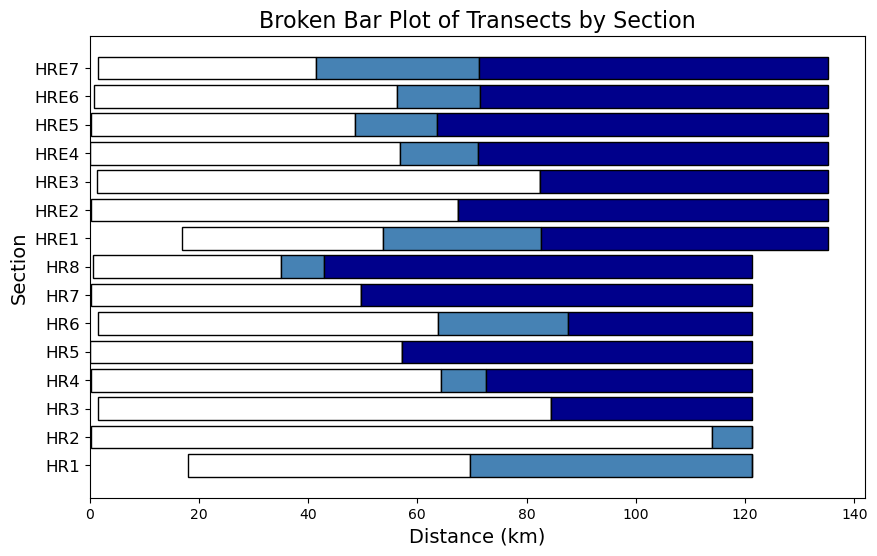

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming hr_hre_ice_edges is your dataframe
# Example data, make sure to replace this with your actual DataFrame
# hr_hre_ice_edges = ...

# Set up the figure
plt.figure(figsize=(10, 6))

# Loop through each row of the dataframe to plot the broken bars
for index, row in hr_hre_ice_edges.iterrows():
    # Get values for plotting
    section = row['section']
    northern_end = row['northern_end_of_transect']
    ice_edge = row['ice_edge']
    miz_edge = row['miz_edge']
    southern_end = row['southern_end_of_transect']
    
    # Plot the first segment (from northern_end to ice_edge, white)
    plt.barh(section, ice_edge - northern_end, left=northern_end, color='white', edgecolor='black')
    
    # Plot the second segment (from ice_edge to miz_edge, steelblue)
    plt.barh(section, miz_edge - ice_edge, left=ice_edge, color='steelblue', edgecolor='black')
    
    # Plot the third segment (from miz_edge to southern_end, dark blue)
    plt.barh(section, southern_end - miz_edge, left=miz_edge, color='darkblue', edgecolor='black')

# Add labels and title
plt.xlabel('Distance (km)', fontsize=14)
plt.ylabel('Section', fontsize=14)
plt.title('Broken Bar Plot of Transects by Section', fontsize=16)

# Optional: Customize y-ticks if the sections are too cluttered
plt.yticks(fontsize=12)

# Show the plot
plt.show()


In [15]:
# hr_hre[hr_hre['ice_edge']==True]

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 [Text(-20.0, 0, '−20'),
  Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100'),
  Text(120.0, 0, '120'),
  Text(140.0, 0, '140'),
  Text(160.0, 0, '160')])

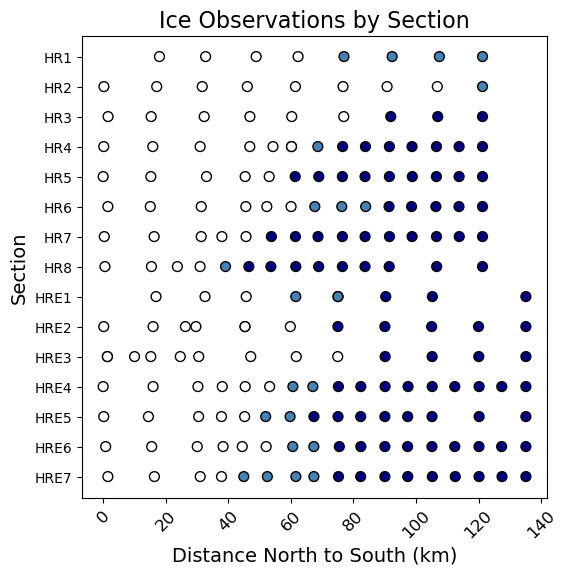

In [16]:
import matplotlib.pyplot as plt

# Define color mapping for categorical data (if necessary)
color_dict = {'ow': 'navy', 'miz': 'steelblue', 'ice': 'white'}
colors = hr_hre['ice_obs'].map(color_dict)

# Create a new figure with a specified size (width, height)
plt.figure(figsize=(6, 6))  # Change the size as needed

# Plot the scatter plot with custom colors
scatter = plt.scatter(y=hr_hre['section'],
                      x=hr_hre['dist_n2s'],
                      c=colors,
                      edgecolors='k',  # Optional: add edge color for better visibility
                      s=50)  # Optional: adjust point size (default is 20)

# Add labels and title
plt.ylabel('Section', fontsize=14)  # Adjust font size for labels
plt.xlabel('Distance North to South (km)', fontsize=14)
plt.title('Ice Observations by Section', fontsize=16)

plt.gca().invert_yaxis()

# # Optionally, adjust grid and ticks
# plt.grid(True)  # Enable grid
plt.xticks(fontsize=12, rotation=45)  # Set font size for x-axis ticks
# plt.yticks(fontsize=12)  # Set font size for y-axis ticks

# Add a color legend
